##  Relationship between age, sex, and cholestorol to do with heart disease.

## Introduction:

**Background:** Heart disease is a term that encompasses several different types of heart conditions(1). The most common condition is know as coronary artery disease (CAD) which can lead to decreased blood flow to the heart resulting in a heart attack (1). As a prominent cause of mortality in Canada, heart disease underscores the significance of investigating factors that may contribute to its development (2).

**Question:** We want to know if age, sex, and cholesterol levels might play a role in the presence or absence of heart disease. 

**ID and Describe the dataset used:** The dataset we are using to answer this question is heart disease dataset from the Cleveland provided to us through the UC Irvine Machine Learning Repository (3). It contains 14 attributes including age, sex, a chest pain scale, resting blood pressure, serum cholesterol, fasting blood sugar levels, resting electrocardiograph results, maximum heart rate achieved, exercise induced angina, ST depression induced by exercise relative to rest, the slope of the peak exercise ST segment, number of major vessels (0-3) colored by fluoroscopy, and diagnosis of heart disease.


In [1]:
install.packages("GGally")
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
source("tests.R")
source("cleanup.R")

also installing the dependencies ‘broom.helpers’, ‘ggplot2’, ‘ggstats’


Warning message in install.packages("GGally"):
“installation of package ‘broom.helpers’ had non-zero exit status”
Warning message in install.packages("GGally"):
“installation of package ‘ggstats’ had non-zero exit status”
Warning message in install.packages("GGally"):
“installation of package ‘GGally’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dial

ERROR: Error in library(GGally): there is no package called ‘GGally’


In [2]:
# reading the dataframe from the document 

heart_data <- read_delim("data/processed.cleveland.data", delim=",", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Here we change all the variables in the data table to accuratly represent what they are

In [3]:
# assigning coloumn names to each column

heart_data <- rename(heart_data,
                    age = X1,
                    sex = X2,
                    cp = X3,
                    trestbps = X4,
                    chol = X5,
                    fbs = X6,
                    restecg = X7,
                    thalach = X8,
                    exang = X9,
                    oldpeak = X10,
                    slope = X11,
                    ca = X12,
                    thal = X13,
                    num = X14)


Here we change all the "?"'s in the data to NA to make it easier to work with 

In [10]:
# removing "?" from data and replacing it with NA

heart_data[heart_data == "?"] <- NA


Here we select all the columns of interest (predictors and what will be predicted)

In [11]:
# selecting columns of interest: age, sex, chol and num

heart_data <- select(heart_data, age, sex, chol, num)


We change catagorical variables into numerical ones to make them easier to work with

In [12]:
heart_data_clean <- heart_data |>
    mutate(sex = as_factor(sex)) |>
    mutate(sex = fct_recode(sex, "M" = "1", "F" = "0")) |>
    mutate(num = as_factor(num)) |>
    mutate(num = fct_recode(num, "H" = "0", "D" = "1", "D" = "2", "D" = "3", "D" = "4"))

Splitting the data frame into training and testing sets with a seed to make data reproducible 

In [15]:
# splitting dataframe into training and testing datasets
set.seed(1234)

heart_split <- initial_split(heart_data_clean, prop = 0.75, strata = num)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

In [16]:
# number of male patients in training dataset
male_count <- heart_training |> filter(sex == "M") |> group_by(num) |> summarize(male = n()) 

#number of female patients in training dataset
female_count <- heart_training |> filter(sex == "F") |> group_by(num) |> summarize(female = n()) 

# joining the male and female tables
sex_join <- full_join(male_count, female_count)

# getting the patient, count, percentage, min, max, count of male and female patients and mean of each predictor
num_obs <- nrow(heart_training)
heart_summary <- heart_training |> 
    group_by(num) |>
    summarize(
        count = n(),
        percentage = n()/num_obs * 100,
        min_age = min(age),
        max_age = max(age),
        mean_age = mean(age),
        min_chol = min(chol),
        max_chol = max(chol),
        mean_chol = mean(chol)) 

heart_summary <- full_join(heart_summary, sex_join)
heart_summary

Joining with `by = join_by(num)`
Joining with `by = join_by(num)`


num,count,percentage,min_age,max_age,mean_age,min_chol,max_chol,mean_chol,male,female
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
H,123,54.18502,29,76,52.52846,126,564,243.0325,69,54
D,104,45.81498,35,70,56.31731,131,409,247.9327,84,20


Creating tables of the number of all female nd male patients, joining them, and aquiring the patient, count, percentage, min, max, and count of male and female patiens as well as the mean of each predictor:

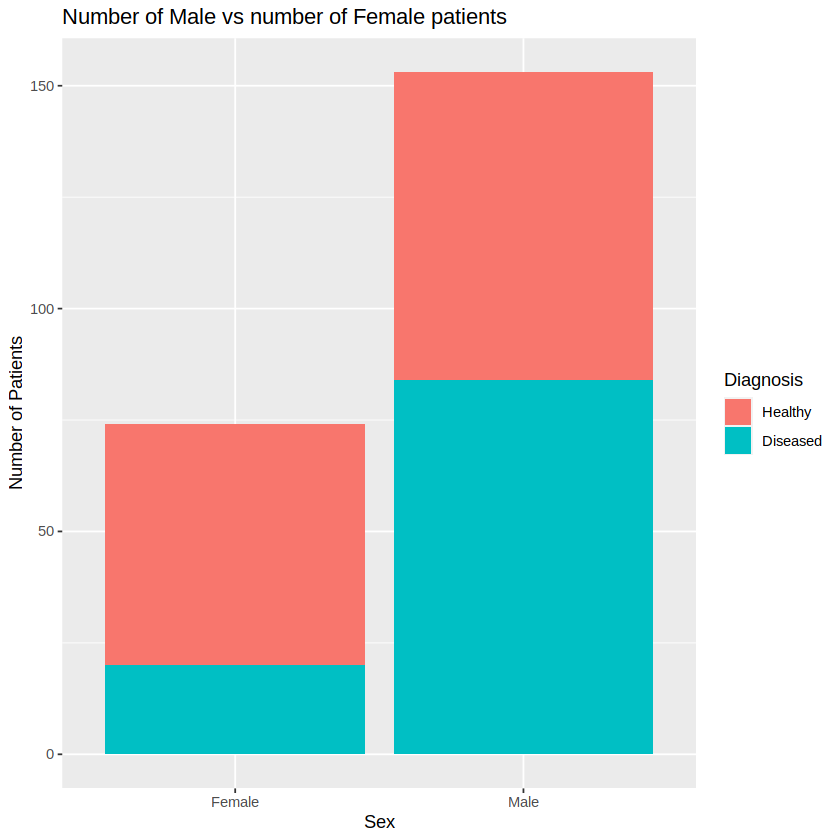

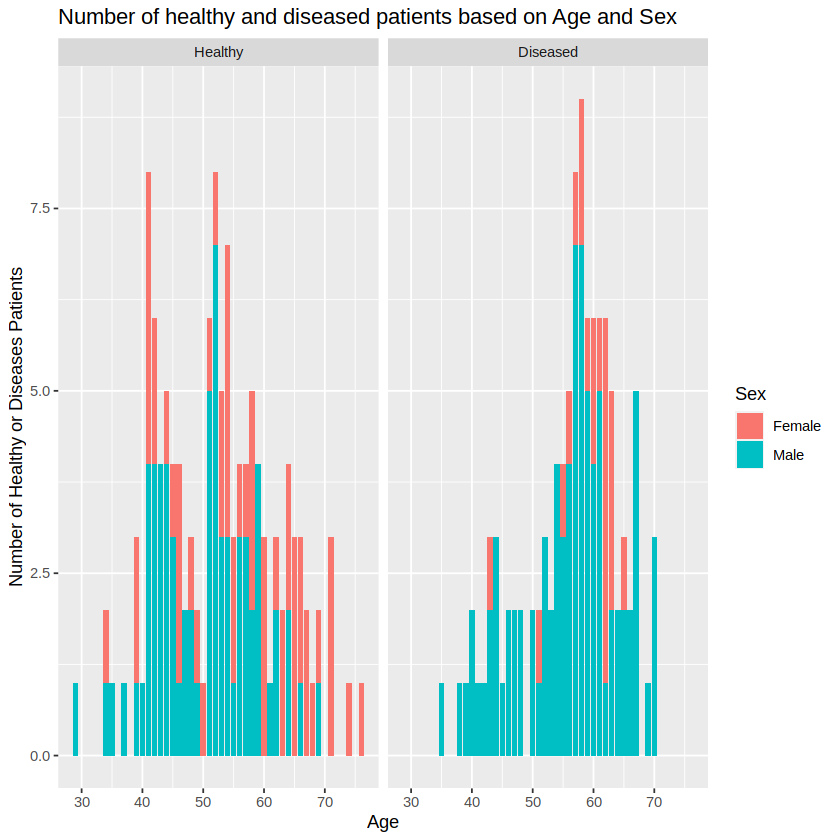

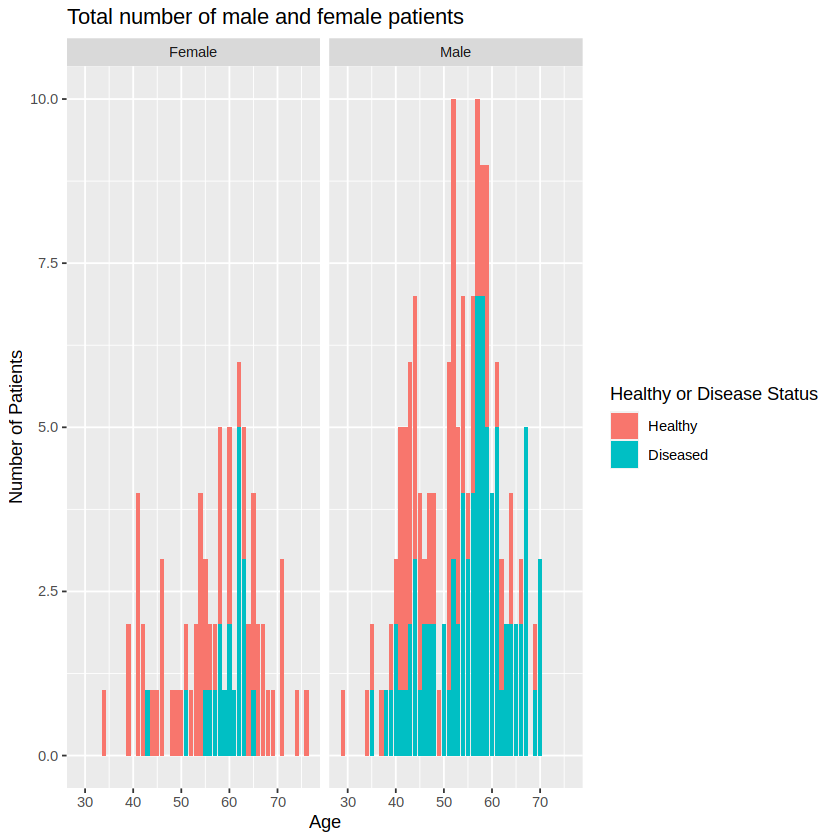

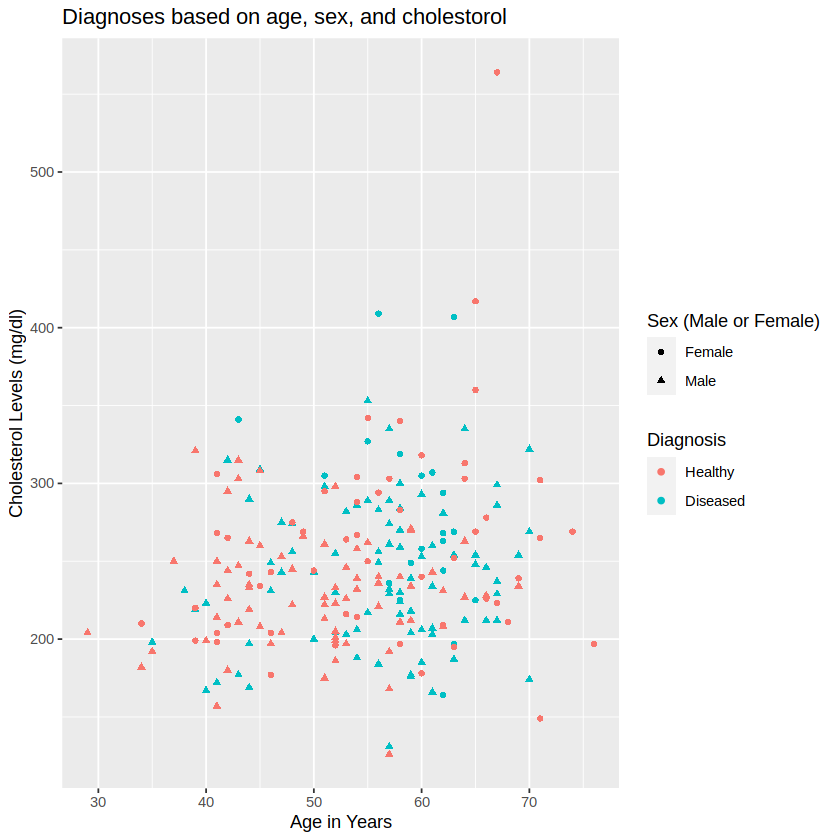

In [18]:
plot1 <- ggplot(heart_training, aes(x = sex,  fill = num)) +
                 geom_bar() +
                 labs(x = "Sex", y = "Number of Patients", fill = "Diagnosis")+
                 scale_fill_discrete(labels = c("Healthy", "Diseased"))+
                 scale_x_discrete(labels = c("F" = "Female", "M" = "Male"))+
                 ggtitle("Number of Male vs number of Female patients")
                 

plot2 <- ggplot(heart_training, aes(x = age, fill = sex)) +
                 geom_bar() +
                 labs(x = "Age", y = "Number of Healthy or Diseases Patients", fill = "Sex") +
                 facet_wrap(~num, labeller = labeller(num = c(H = "Healthy", D = "Diseased"))) +
                 scale_fill_discrete(labels = c("Female", "Male"))+
                 ggtitle("Number of healthy and diseased patients based on Age and Sex")

plot3 <- ggplot(heart_training, aes(x = age, fill = num)) +
                 geom_bar() +
                 labs(x = "Age", y = "Number of Patients", fill = "Healthy or Disease Status") +
                 facet_wrap(~sex, labeller = labeller(sex = c(F = "Female", M = "Male"))) +
                 scale_fill_discrete(labels = c("Healthy", "Diseased"))+
                 ggtitle("Total number of male and female patients")



plot4 <- ggplot(heart_training, aes(x = age, y = chol, color = num, shape = sex)) +
                 geom_point() +
                 labs(x = "Age in Years", y = "Cholesterol Levels (mg/dl)", color = "Diagnosis", shape = "Sex (Male or Female)")+
                 ggtitle("Diagnoses based on age, sex, and cholestorol")+
                 scale_color_discrete(labels = c("Healthy", "Diseased")) +
                 scale_shape_discrete(labels = c("Female", "Male"))

plot1
plot2
plot3
plot4

## Methods

We used the processed.cleveland.data file from the Heart Disease database to predict if a patient from Cleveland will be diagnosed with heart disease. The original file contains 14 columns as listed below. 

1. **age:** age in years

2. **sex:** male ("M") or female ("F")

3. **cp:** chest pain type (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)

4. **trestbps:** resting blood pressure (on admission to the hospital)

5. **chol:** serum cholesterol in mg/dl

6. **fbs:** fasting blood sugar > 120 mg/dl

7. **restecg:** resting electrocardiographic results (Value 0: normal, Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), Value 2: showing probable or definite left ventricular hypertrophy by Estes criteria)

8. **thalach:** maximum heart rate achieved

9. **exang:** exercise induced angina

10. **oldpeak:** ST depression induced by exercise relative to rest

11. **slope:** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)

12. **ca:** number of major vessels (0-3) coloured by fluoroscopy

13. **thal:** 3 = normal; 6 = fixed defect; 7 = reversable defect

14. **num:** diagnosis of heart disease


We decided to narrow down our focus to age, gender, cholesterol levels, and the diagnosis of heart disease by excluding all other columns. We made this choice to streamline our dataset, as carrying unnecessary data can potentially slow down computations and make the data less readable. The reason we chose age gender and cholestorol is because they both have high correlation with the diagnosis of heart disease, and because many of the other variables are subjective or catagorical and less related than gender.

We began by data cleaning, replacing all "?" values with NA. Our primary objective was to identify the presence or absence of heart disease, so we transformed the "num" column to represent "H" for a healthy state and "D" for a heart disease diagnosis. We then employed "initial_split" to partition the dataframe, allocating 75% for training and 25% for testing.

For a comprehensive data overview, we grouped by the "num" category and calculated statistics including minimum, maximum, and mean values. We further enriched this summary by merging it with two additional tables detailing heart disease diagnoses for both genders. Notably, we observed that individuals diagnosed with heart disease tended to be older, and a higher proportion of men exhibited heart disease than women.

To gain insights into our data relationships, we created scatter plots and bar charts. These visualizations enabled us to explore associations between patient age and cholesterol levels and their correlation with heart disease occurrences. Additionally, a bar graph was used to illustrate the gender-based distribution of heart disease diagnoses among men and women.


## Expected Outcomes
**What do you expect to find?**

We anticipate uncovering insights into the relationship between age, sex, cholesterol levels and the presence or absence of heart disease. These findings could shed light on potential risk factors and help develop targeted interventions for at-risk populations.

**What impact could such findings have?**

The impact of these findings could be significant in terms of public health. Understanding how age, sex, and cholesterol levels influence heart disease can inform preventive strategies and healthcare policies, ultimately reducing the burden of heart disease in Canada.

**What future questions could this lead to?**

These findings may lead to several follow-up questions and research directions, such as:

1. Are there other demographic or lifestyle factors that interact with age, sex, and cholesterol levels to influence heart disease risk?

2. How can the knowledge gained be translated into personalized healthcare interventions?

3. Can the dataset be expanded or combined with other sources to provide a more comprehensive understanding of heart disease risk factors?

4. What are the long-term health implications for individuals who are at higher risk due to age, sex, and cholesterol levels and how can these be mitigated?

Answering these questions could further advance our understanding of heart disease and guide efforts to prevent and manage it effectively.


## References

1. https://www.cdc.gov/heartdisease/about.htm#:~:text=What%20is%20heart%20disease%3F,can%20cause%20a%20heart%20attack.

2. https://www150.statcan.gc.ca/n1/daily-quotidien/230828/dq230828b-eng.htm

3. Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

